In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from infrasim.optimise import *
from infrasim.utils import *

## Run scenarios
Here we run the model across all five scenarios and append the results into a dictionary

In [9]:
#File paths
nodes = '../data/nextra/spatial/network/nodes.shp'
edges = '../data/nextra/spatial/network/edges.shp'
flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'

# Params
timesteps=None
super_source=False
pprint=True
save_figures=True

infrasim_init_directories()

scenarios = {'BAS' : False,
             'BAU' : True,
             'NCO' : True,
             'EAG' : True,
             'COO' : True,
             'UTO' : True,}

results = {}
for s in scenarios:
    
    model_run = nextra(nodes,edges,flows,
                       scenario=s,
                       energy_objective=scenarios[s],
                       timesteps=timesteps,
                       #super_source=True,
                       #super_sink=True,
                       #res_factor=99,
                       #model_name='meow',
                      )

    model_run.build()
    model_run.run(pprint=False)
    model_run = model_run.get_results()
    # add scenarios to results
    if s == 'BAU' and scenarios[s] == False:
        s = 'BAS'
        
    model_run.results_capacities['scenario'] = s
    model_run.results_storages['scenario'] = s
    model_run.results_edge_flows['scenario'] = s
    # append results
    results[s] = model_run
    
    print('> Completed: ' + s)
    
print('> Done.')   


> Completed: BAS

> Completed: BAU

> Completed: NCO

> Completed: EAG

> Completed: COO

> Completed: UTO
> Done.


## Create capacities figure
This figure will show the required capacity (GW) in 2030 per scenario as a bar chart

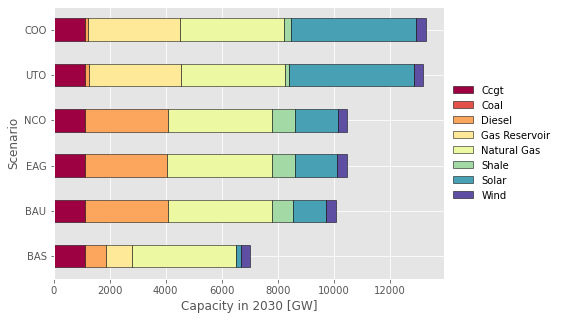

In [41]:
def merge_capacity_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    capacities = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_capacities
        capacities = capacities.append(df,ignore_index=True)
    # map technologies and territories
    capacities = map_tech_and_territory(results['BAU'],capacities,col_to_map='node')
    return capacities

# run function
capacities = merge_capacity_data(results)
# convert to gw
#capacities['value'] = capacities['value'].apply(lambda row: mw_to_gw(row))
# pivot for bar chart
capacities = capacities.pivot_table(index=['scenario'],
                                    columns=['technology'],
                                    values='value')
# sort by ascending
capacities['total'] = capacities.sum(axis=1)
capacities = capacities.sort_values("total").drop('total',axis=1)

# plot
plt.style.use('ggplot')
f,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
capacities.plot.barh(stacked=True,rot=0,ax=ax,cmap='Spectral',edgecolor='black')
ax.set_xlabel('Capacity in 2030 [GW]')
ax.set_ylabel('Scenario')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),frameon=False)

## Relative capacity change
This figure shows the capacity change (GW) per scenario relative to BAS

technology,Ccgt,Coal,Diesel,Gas Reservoir,Natural Gas,Shale,Solar,Wind
scenario,,,,,,,,
BAS,1133.333333,0.0,721.131033,931.528949,3711.75,0.000000,174.500000,339.666667
BAU,1133.333333,0.0,2945.147100,0.000000,3711.75,744.688977,1199.364035,339.666667
EAG,1133.333333,0.0,2930.406563,0.000000,3711.75,855.847959,1495.940004,339.666667
NCO,1133.333333,0.0,2933.362294,0.000000,3711.75,820.667471,1547.326736,339.666667
UTO,1133.333333,0.0,135.000000,3262.422759,3711.75,158.990753,4449.997330,339.666667
COO,1133.333333,0.0,107.882308,3262.422759,3711.75,267.461521,4449.997330,339.666667


In [6]:
results

{'BAU': <infrasim.postprocess.nextra_postprocess at 0x183f9fb80>,
 'NCO': <infrasim.postprocess.nextra_postprocess at 0x18cdbeb80>,
 'EAG': <infrasim.postprocess.nextra_postprocess at 0x1c08993a0>,
 'COO': <infrasim.postprocess.nextra_postprocess at 0x18cdbe730>,
 'UTO': <infrasim.postprocess.nextra_postprocess at 0x1c0cd9190>}